# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from the built-in CellTypist models.

## Install CellTypist

In [ ]:
%%capture --no-display
import anndata
import scanpy as sc
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
#import besca
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import operator
import celltypist
from celltypist import models

## Load a scRNA-seq dataset .h5ad file

In [4]:
import scanpy as sc
import pandas as pd

# Load expression matrix
adata = sc.read_10x_mtx(
"../datasets",
var_names="gene_symbols",
cache=True
)

adata.var_names_make_unique()

# Load metadata
meta = pd.read_csv("../datasets/metadata.csv.gz")
meta.columns = ["cell_id", "tissue", "patient", "cell-type"]

# Filter metadata for patient PA04 and Tumor tissue
meta_filtered = meta[(meta["patient"] == "PA04") & (meta["tissue"] == "Adjacent_normal")]

# Subset AnnData to matching cells
adata = adata[adata.obs_names.isin(meta_filtered["cell_id"])].copy()
meta_filtered = meta_filtered.set_index("cell_id")
adata.obs = adata.obs.join(meta_filtered)

print(adata)
print(adata.obs.head())

AnnData object with n_obs × n_vars = 10816 × 30543
    obs: 'tissue', 'patient', 'cell-type'
    var: 'gene_ids', 'feature_types'
                                                   tissue patient cell-type
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1  Adjacent_normal    PA04         B
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1  Adjacent_normal    PA04         B
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1  Adjacent_normal    PA04         B
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1  Adjacent_normal    PA04      CD8T
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1  Adjacent_normal    PA04      CD8T


In [5]:
min_count = adata.X.min()
max_count = adata.X.max()

print(f"Minimum transcript count: {min_count}")
print(f"Maximum transcript count: {max_count}")

Minimum transcript count: 0.0
Maximum transcript count: 9545.0


In [6]:
#annotate mitochondrial, ribosomal, and hemoglobin genes 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL")) 
adata.var['hb'] = adata.var_names.str.startswith("^HB[^(P)]") 

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

#print(f"Number of cells: {adata.n_obs}\n Number of genes: {adata.n_vars}")
print(f"{adata.obs['patient'].value_counts().to_string()} cells and {adata.n_vars} genes BEFORE min cutoff")

adata_for_median_genes=adata.copy(adata)
adata_post=adata.copy(adata)

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(f"{adata.obs['patient'].value_counts().to_string()} cells and {adata.n_vars} genes AFTER min cutoff")

# This will store the normalized data in adata_filter.X
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
# This will apply log1p to the normalized data in adata_filter.X
sc.pp.log1p(adata)

patient
PA04    10816 cells and 30543 genes BEFORE min cutoff
patient
PA04    10816 cells and 18440 genes AFTER min cutoff


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from a custom model to the query dataset.

In [8]:
import celltypist
from celltypist import models
## REPLACE <YOUR MODEL FILENAME> with the PKL file you made
custom_model = models.Model.load(model = '../UCSC_tabula_sapiens_human_pancreas_model.pkl')

Show the built-in model meta information:

In [9]:
custom_model

CellTypist model with 15 cell types and 51863 features
    date: 2025-09-25 16:27:20.330462
    cell types: b cell, endothelial cell, ..., t cell
    features: WASH7P, MIR6859-1, ..., MT-TP

#### This model contains 15 cell states.

In [10]:
custom_model.cell_types

array(['b cell', 'endothelial cell', 'fibroblast', 'mast cell',
       'myeloid cell', 'nk cell', 'pancreatic acinar cell',
       'pancreatic alpha cell', 'pancreatic beta cell',
       'pancreatic delta cell', 'pancreatic ductal cell',
       'pancreatic pp cell', 'pancreatic stellate cell', 'plasma cell',
       't cell'], dtype='<U24')

### Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [11]:
predictions = celltypist.annotate(adata, custom_model, majority_voting = True)

🔬 Input data has 10816 cells and 18440 genes
🔗 Matching reference genes in the model
🧬 17799 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [12]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,b cell,0,b cell
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,b cell,2,b cell
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,b cell,7,b cell
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,t cell,10,t cell
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,t cell,11,t cell
...,...,...,...
PDAC04-Normal-GEX_out_TTTGTCATCGATCCCT-1,b cell,24,b cell
PDAC04-Normal-GEX_out_TTTGTCATCGGCATCG-1,t cell,31,t cell
PDAC04-Normal-GEX_out_TTTGTCATCTAACTTC-1,t cell,13,t cell
PDAC04-Normal-GEX_out_TTTGTCATCTCAACTT-1,t cell,30,t cell


### Transform the prediction result into an `AnnData`.

In [13]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [14]:
adata.obs

,tissue,patient,cell-type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,n_genes,predicted_labels,over_clustering,majority_voting,conf_score
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,Adjacent_normal,PA04,B,1404,2724.0,97.0,3.560940,0.0,0.0,0.0,0.0,1404,b cell,0,b cell,3.120934e-199
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,Adjacent_normal,PA04,B,4265,16713.0,602.0,3.601987,0.0,0.0,0.0,0.0,4265,b cell,2,b cell,1.000000e+00
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,Adjacent_normal,PA04,B,1621,3903.0,142.0,3.638227,0.0,0.0,0.0,0.0,1621,b cell,7,b cell,1.000000e+00
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,Adjacent_normal,PA04,CD8T,1174,2438.0,74.0,3.035275,0.0,0.0,0.0,0.0,1174,t cell,10,t cell,1.000000e+00
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,Adjacent_normal,PA04,CD8T,1346,3113.0,51.0,1.638291,0.0,0.0,0.0,0.0,1346,t cell,11,t cell,1.987275e-171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDAC04-Normal-GEX_out_TTTGTCATCGATCCCT-1,Adjacent_normal,PA04,B,1161,2197.0,54.0,2.457897,0.0,0.0,0.0,0.0,1161,b cell,24,b cell,1.646081e-46
PDAC04-Normal-GEX_out_TTTGTCATCGGCATCG-1,Adjacent_normal,PA04,CD4T,1557,4046.0,92.0,2.273851,0.0,0.0,0.0,0.0,1557,t cell,31,t cell,1.000000e+00
PDAC04-Normal-GEX_out_TTTGTCATCTAACTTC-1,Adjacent_normal,PA04,CD4T,1471,3433.0,59.0,1.718614,0.0,0.0,0.0,0.0,1471,t cell,13,t cell,1.000000e+00
PDAC04-Normal-GEX_out_TTTGTCATCTCAACTT-1,Adjacent_normal,PA04,CD4T,1356,2836.0,47.0,1.657264,0.0,0.0,0.0,0.0,1356,t cell,30,t cell,1.000000e+00


In [15]:
adata = adata[adata.obs['conf_score'] > 0].copy()

In [16]:
adata.obs

,tissue,patient,cell-type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,n_genes,predicted_labels,over_clustering,majority_voting,conf_score
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,Adjacent_normal,PA04,B,1404,2724.0,97.0,3.560940,0.0,0.0,0.0,0.0,1404,b cell,0,b cell,3.120934e-199
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,Adjacent_normal,PA04,B,4265,16713.0,602.0,3.601987,0.0,0.0,0.0,0.0,4265,b cell,2,b cell,1.000000e+00
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,Adjacent_normal,PA04,B,1621,3903.0,142.0,3.638227,0.0,0.0,0.0,0.0,1621,b cell,7,b cell,1.000000e+00
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,Adjacent_normal,PA04,CD8T,1174,2438.0,74.0,3.035275,0.0,0.0,0.0,0.0,1174,t cell,10,t cell,1.000000e+00
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,Adjacent_normal,PA04,CD8T,1346,3113.0,51.0,1.638291,0.0,0.0,0.0,0.0,1346,t cell,11,t cell,1.987275e-171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDAC04-Normal-GEX_out_TTTGTCATCGATCCCT-1,Adjacent_normal,PA04,B,1161,2197.0,54.0,2.457897,0.0,0.0,0.0,0.0,1161,b cell,24,b cell,1.646081e-46
PDAC04-Normal-GEX_out_TTTGTCATCGGCATCG-1,Adjacent_normal,PA04,CD4T,1557,4046.0,92.0,2.273851,0.0,0.0,0.0,0.0,1557,t cell,31,t cell,1.000000e+00
PDAC04-Normal-GEX_out_TTTGTCATCTAACTTC-1,Adjacent_normal,PA04,CD4T,1471,3433.0,59.0,1.718614,0.0,0.0,0.0,0.0,1471,t cell,13,t cell,1.000000e+00
PDAC04-Normal-GEX_out_TTTGTCATCTCAACTT-1,Adjacent_normal,PA04,CD4T,1356,2836.0,47.0,1.657264,0.0,0.0,0.0,0.0,1356,t cell,30,t cell,1.000000e+00


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [17]:
sc.tl.umap(adata)

### Visualise the prediction results.

... storing 'tissue' as categorical
... storing 'patient' as categorical
... storing 'cell-type' as categorical
... storing 'feature_types' as categorical


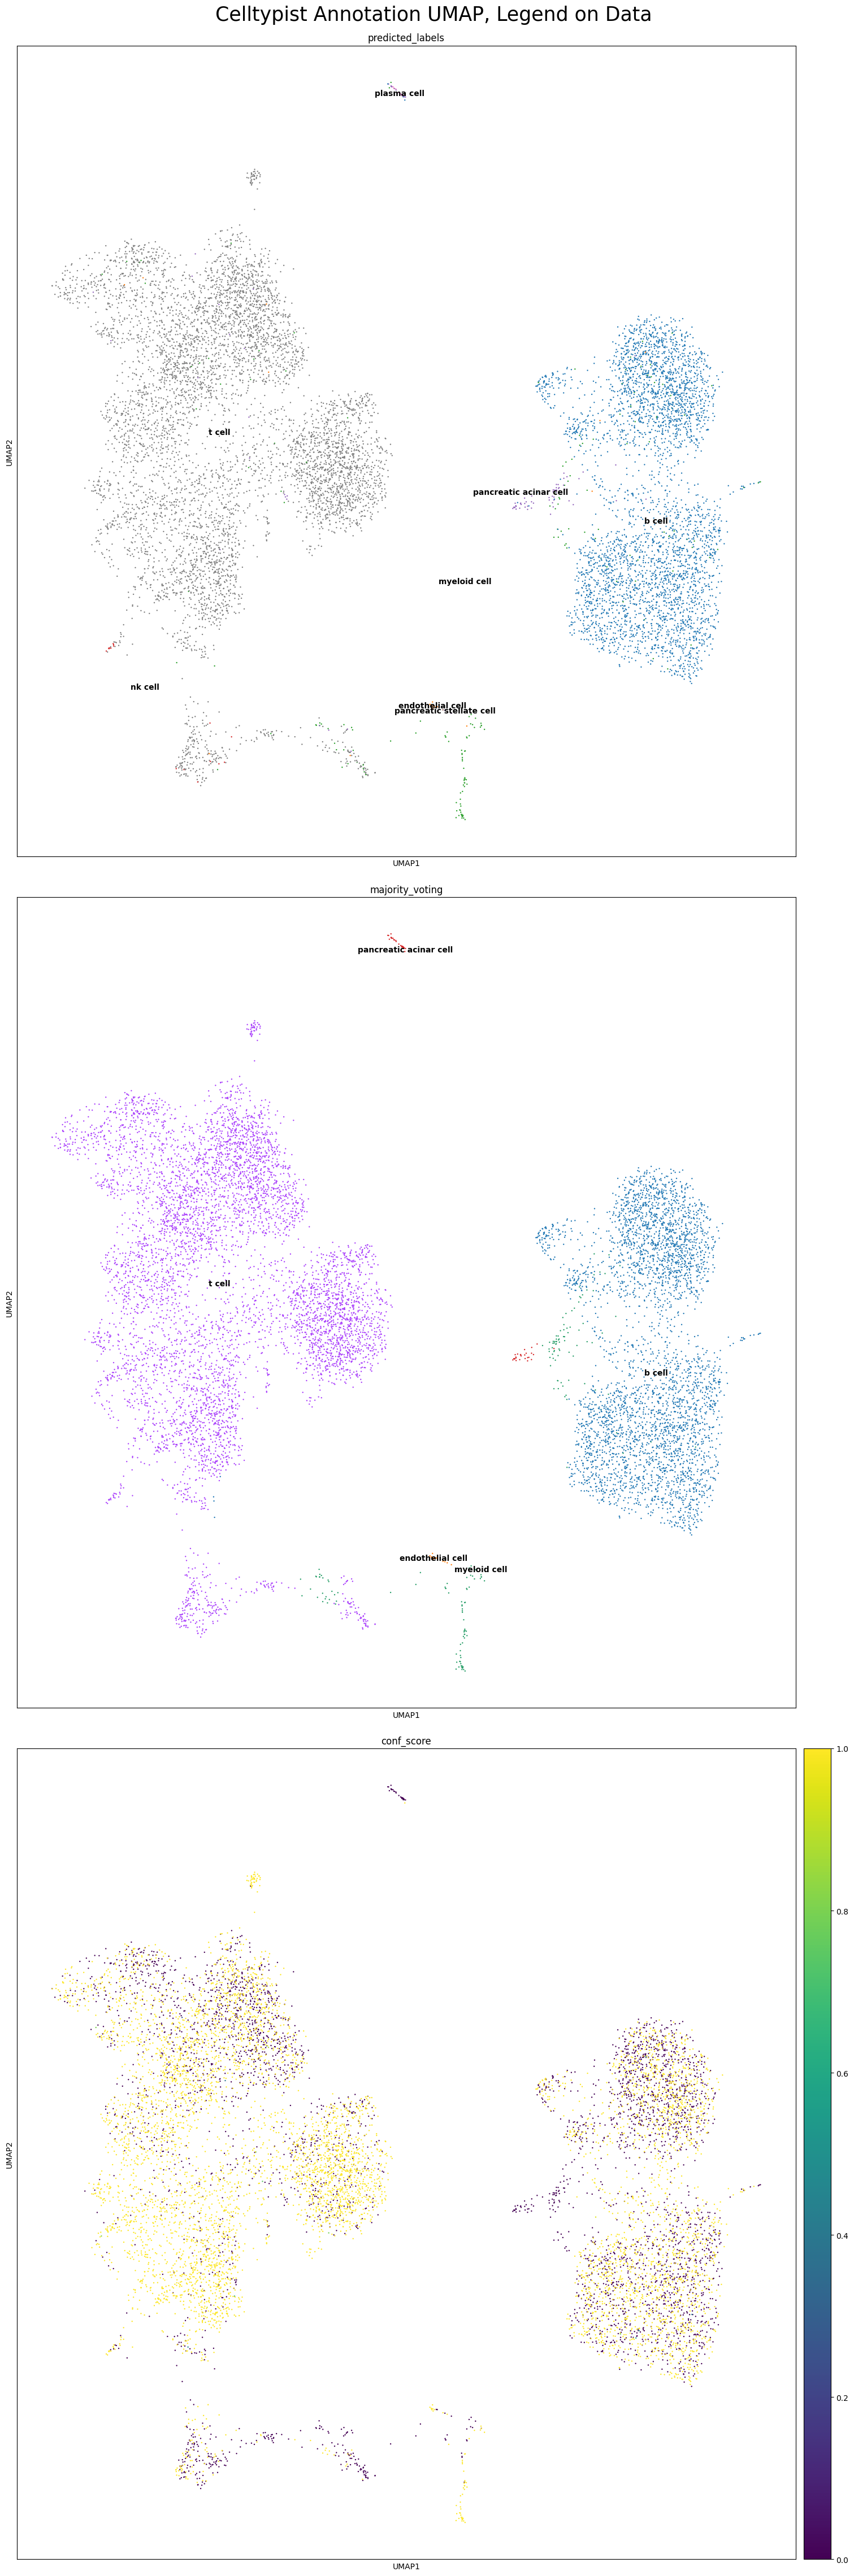

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,1,figsize = (15,45), constrained_layout=True)

fig.suptitle("Celltypist Annotation UMAP, Legend on Data", x=0.25, y=1.01, horizontalalignment='left', fontsize=25)

ax[0].set_title('Predicted Labels'),
predicted_label_UMAP=sc.pl.umap(adata, color = ['predicted_labels'], legend_loc = 'on data',ax=ax[0], show=False) 

ax[1].set_title('Majority Voting'),
majority_vote_UMAP=sc.pl.umap(adata, color = ['majority_voting'], palette=sc.pl.palettes.default_20, legend_loc = 'on data', ax=ax[1], show=False)
    
ax[2].set_title('Confidence Score'),
conf_score_UMAP=sc.pl.umap(adata, color = ['conf_score'], legend_loc = 'on data', ax=ax[2])
  

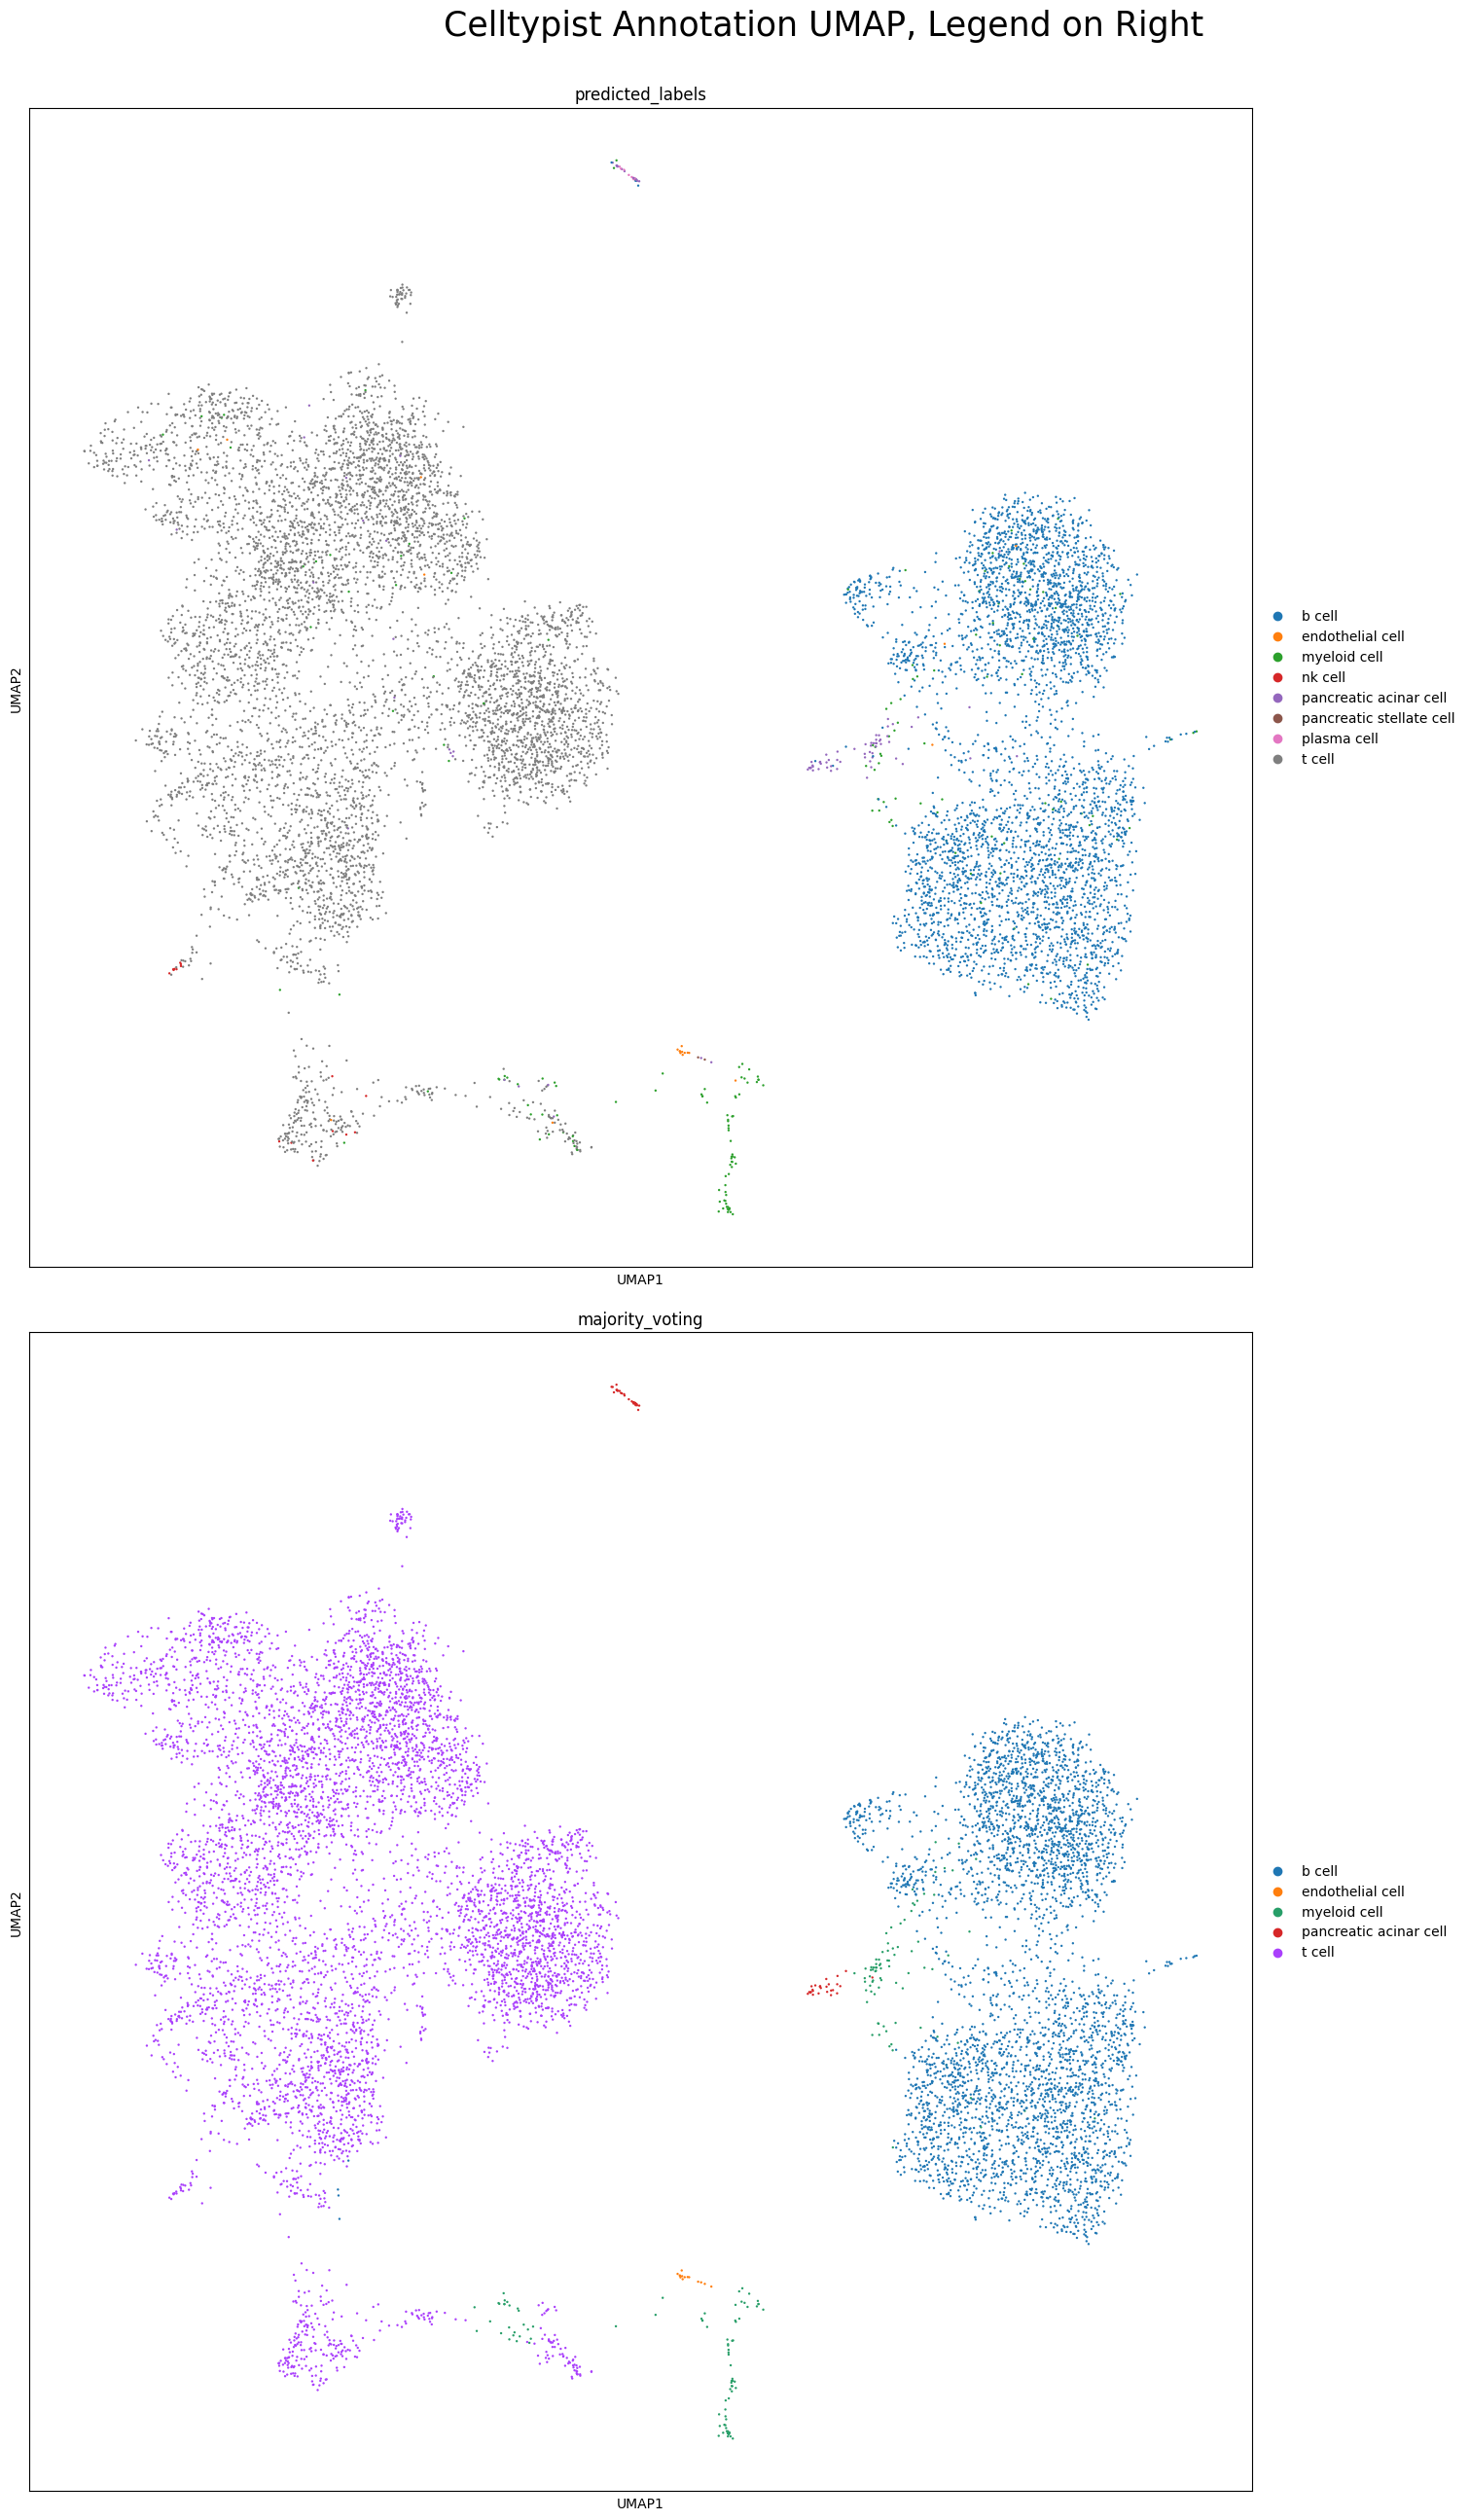

In [20]:
fig, ax = plt.subplots(2,1,figsize = (15,25), constrained_layout=True)

fig.suptitle("Celltypist Annotation UMAP, Legend on Right", x=0.3, y=1.03, horizontalalignment='left', fontsize=25)

ax[0].set_title('Predicted Labels'),
predicted_label_UMAP=sc.pl.umap(adata, color = ['predicted_labels'], legend_loc = 'right margin',ax=ax[0], show=False) 

ax[1].set_title('Majority Voting'),
majority_vote_UMAP=sc.pl.umap(adata, color = ['majority_voting'], palette=sc.pl.palettes.default_20, legend_loc = 'right margin', ax=ax[1], show=False)

In [ ]:
#unique_sample_names = adata.obs['sample'].unique().tolist()

#for sample in unique_sample_names:
    # Filter the AnnData object to include only rows with the current sample
    #subset_adata_built_in = adata[adata.obs['sample'] == sample, :]

    # Count occurrences for the current sample
    #count_types = besca.tl.count_occurrence(subset_adata_built_in, count_variable='majority_voting', add_percentage=False)
    #print(sample)
    #print('-----------')
    #print(count_types)
    #print('-----------')

## Examine TLS Genes of Interest

#### Here you can plug in the genes of interest associated with TLS formation in your patients and light up the cells expressing those genes

In [48]:
# REPLACE PLACEHOLDER GENE NAMES HERE WITH GENE SYMBOLS
examine_genes_t_cell_markers = ['CCL5','CMTM3','CKLF']
subset_ad_tcell_markers = adata[:, examine_genes_t_cell_markers]

examine_genes_b_cell_markers = ["CXCR5", "CXCL13", "TNFSF13B"]
subset_ad_bcell_markers = adata[:, examine_genes_b_cell_markers]

examine_genes_myeloid_markers = ["IL23A", "CXCL13", "CCL19"]
subset_ad_myeloid_markers = adata[:, examine_genes_myeloid_markers]

subset_ad_tcell_markers.var
subset_ad_bcell_markers.var
subset_ad_myeloid_markers.var

,gene_ids,feature_types,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
IL23A,IL23A,Gene Expression,False,False,False,1476,0.192955,86.353550,2087.0,1476
CXCL13,CXCL13,Gene Expression,False,False,False,33,0.029031,99.694896,314.0,33
CCL19,CCL19,Gene Expression,False,False,False,9,0.001664,99.916790,18.0,9


In [50]:
subset_df_T = pd.DataFrame(subset_ad_tcell_markers.X.toarray(), index=subset_ad_tcell_markers.obs_names, columns=examine_genes_t_cell_markers)
subset_df_B = pd.DataFrame(subset_ad_bcell_markers.X.toarray(), index=subset_ad_bcell_markers.obs_names, columns=examine_genes_b_cell_markers)
subset_df_M = pd.DataFrame(subset_ad_myeloid_markers.X.toarray(), index=subset_ad_myeloid_markers.obs_names, columns=examine_genes_myeloid_markers)

# subset_df_T
subset_df_B
# subset_df_M

,CXCR5,CXCL13,TNFSF13B
PDAC04-Normal-GEX_out_AAACCTGAGCTGTTCA-1,0.000000,0.0,0.0
PDAC04-Normal-GEX_out_AAACCTGAGGAGTACC-1,1.384213,0.0,0.0
PDAC04-Normal-GEX_out_AAACCTGAGGCCATAG-1,0.000000,0.0,0.0
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,0.000000,0.0,0.0
PDAC04-Normal-GEX_out_AAACCTGCAAGCCCAC-1,0.000000,0.0,0.0
...,...,...,...
PDAC04-Normal-GEX_out_TTTGTCATCGATCCCT-1,2.684781,0.0,0.0
PDAC04-Normal-GEX_out_TTTGTCATCGGCATCG-1,0.000000,0.0,0.0
PDAC04-Normal-GEX_out_TTTGTCATCTAACTTC-1,0.000000,0.0,0.0
PDAC04-Normal-GEX_out_TTTGTCATCTCAACTT-1,0.000000,0.0,0.0


In [52]:
## Create columns for the genes of interest

## Add cell type annotation
ad_df_w_annot_t = sc.get.obs_df(subset_ad_tcell_markers, examine_genes_t_cell_markers + ['patient', 'predicted_labels','majority_voting'], use_raw=False)
ad_df_w_annot_b = sc.get.obs_df(subset_ad_bcell_markers, examine_genes_b_cell_markers + ['patient', 'predicted_labels','majority_voting'], use_raw=False)
ad_df_w_annot_m = sc.get.obs_df(subset_ad_myeloid_markers, examine_genes_myeloid_markers + ['patient', 'predicted_labels','majority_voting'], use_raw=False)

## Display the table with annotation
# ad_df_w_annot_m

In [ ]:
import operator
from functools import reduce

# Step 1: Create a dictionary of boolean Series (True if gene expression > 0)
nonzero_dict_t = {gene: (ad_df_w_annot_t[gene] > 0) for gene in examine_genes_t_cell_markers}
nonzero_dict_b = {gene: (ad_df_w_annot_b[gene] > 0) for gene in examine_genes_b_cell_markers}
nonzero_dict_m = {gene: (ad_df_w_annot_m[gene] > 0) for gene in examine_genes_myeloid_markers}

# Step 2: Combine all Series using logical AND to get cells expressing all genes
all_nonzero_t = reduce(operator.and_, nonzero_dict_t.values())
all_nonzero_b = reduce(operator.and_, nonzero_dict_b.values())
all_nonzero_m = reduce(operator.and_, nonzero_dict_m.values())

# Step 3: Convert the combined boolean Series to a DataFrame
df_genes_bool_t = all_nonzero_t.to_frame(name='TLS_Genes')
df_genes_bool_b = all_nonzero_t.to_frame(name='TLS_Genes')
df_genes_bool_m = all_nonzero_t.to_frame(name='TLS_Genes')

# Step 4: Convert each gene's boolean Series into a DataFrame with '_bool' suffix
gene_bool_dfs_t = {
    f"df_{gene}_bool": series.to_frame(name=f"{gene}_bool")
    for gene, series in nonzero_dict_t.items()
}

gene_bool_dfs_b = {
    f"df_{gene}_bool": series.to_frame(name=f"{gene}_bool")
    for gene, series in nonzero_dict_b.items()
}

gene_bool_dfs_m = {
    f"df_{gene}_bool": series.to_frame(name=f"{gene}_bool")
    for gene, series in nonzero_dict_m.items()
}

# Step 5: Subset the original dataframe to get rows where all genes are expressed
ad_tls_t = ad_df_w_annot_t.loc[all_nonzero_t, :]
ad_tls_b = ad_df_w_annot_b.loc[all_nonzero_b, :]
ad_tls_m = ad_df_w_annot_m.loc[all_nonzero_m, :]

In [60]:
## List cell barcodes that pass the TRUE check where all TLS-associated genes are expressed
ad_tls_t

,CCL5,CMTM3,CKLF,patient,predicted_labels,majority_voting
PDAC04-Normal-GEX_out_AAACCTGAGGCTCAGA-1,3.242996,1.629578,1.629578,PA04,t cell,t cell
PDAC04-Normal-GEX_out_AAACGGGTCCAAACAC-1,2.333811,0.846309,0.510133,PA04,t cell,t cell
PDAC04-Normal-GEX_out_AAAGTAGAGCGATATA-1,4.082541,1.701890,1.701890,PA04,t cell,t cell
PDAC04-Normal-GEX_out_AACCATGGTCACACGC-1,3.528596,1.542255,1.542255,PA04,t cell,t cell
PDAC04-Normal-GEX_out_AACGTTGCACATGACT-1,3.506466,1.249026,1.249026,PA04,t cell,t cell
...,...,...,...,...,...,...
PDAC04-Normal-GEX_out_TTCTACACAAGGACTG-1,4.846754,1.800563,1.800563,PA04,t cell,t cell
PDAC04-Normal-GEX_out_TTGACTTTCAGTGTTG-1,4.370753,1.883852,1.883852,PA04,t cell,t cell
PDAC04-Normal-GEX_out_TTGGCAAAGATGTTAG-1,1.242370,0.802856,0.802856,PA04,myeloid cell,myeloid cell
PDAC04-Normal-GEX_out_TTGGCAAAGTCCAGGA-1,4.180533,1.521222,2.098709,PA04,t cell,t cell


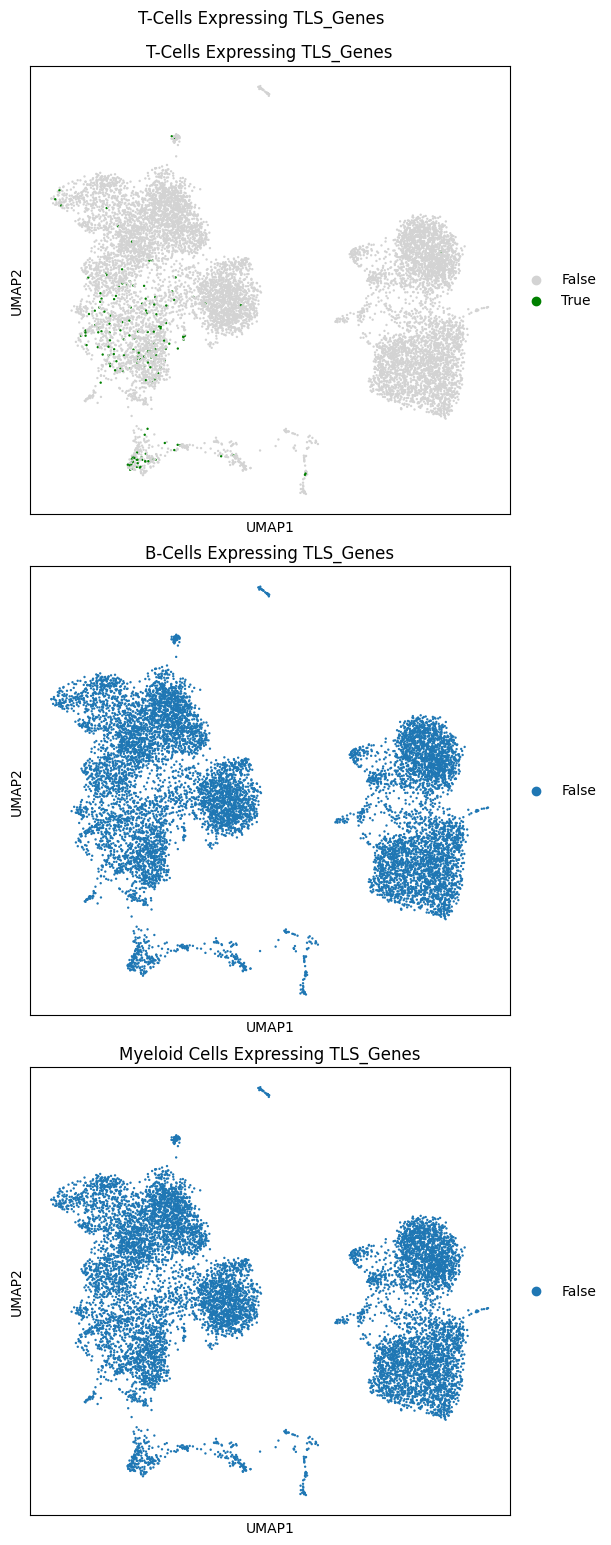

In [ ]:
# Subset table "NI_Genes" containing cells expressing all genes of interest
adata.obs['T-Cell_TLS_Genes'] = all_nonzero_t
adata.obs['B-Cell_TLS_Genes'] = all_nonzero_b
adata.obs['Myeloid-Cell_TLS_Genes'] = all_nonzero_m


# adata.obs['TLS_Genes'] = adata.obs['TLS_Genes'].astype(str).astype('category')

# Create subplots with specific size
fig, ax = plt.subplots(3, 1, figsize=(6, 15), constrained_layout=True)

# Set the title of the entire figure
fig.suptitle("T-Cells Expressing TLS_Genes", x=0.22, y=1.02, horizontalalignment='left', fontsize=12)

# Plot UMAP on the second axis (highlight cells with legend on the margin)
ax[0].set_title('Cells Expressing TLS_Genes')
on_data_UMAP = sc.pl.umap(
    adata, 
    color='T-Cell_TLS_Genes', 
    legend_loc='right margin', 
    title='T-Cells Expressing TLS_Genes', 
    frameon=True, 
    ax=ax[0], 
    show=False
)

ax[1].set_title('B-Cells Expressing TLS_Genes')
on_data_UMAP = sc.pl.umap(
    adata, 
    color='B-Cell_TLS_Genes', 
    legend_loc='right margin', 
    title='B-Cells Expressing TLS_Genes', 
    frameon=True, 
    ax=ax[1], 
    show=False
)

ax[2].set_title('Myeloid Cells Expressing TLS_Genes')
on_data_UMAP = sc.pl.umap(
    adata, 
    color='Myeloid-Cell_TLS_Genes', 
    legend_loc='right margin', 
    title='Myeloid Cells Expressing TLS_Genes', 
    frameon=True, 
    ax=ax[2], 
    show=False
)


## Celltypist Predicted Labels to Majority Voting Dotplot

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

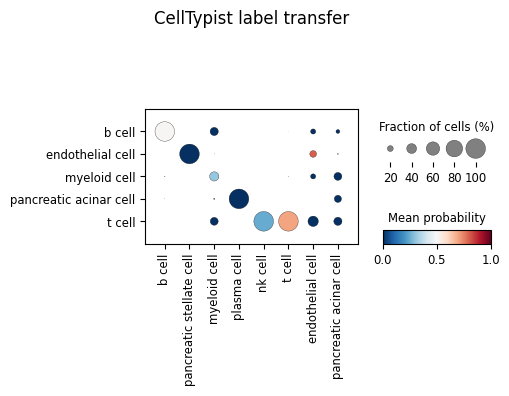

In [73]:
celltypist.dotplot(predictions, use_as_reference = 'predicted_labels', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Pick a cell type from the model:

In [74]:
custom_model.cell_types

array(['b cell', 'endothelial cell', 'fibroblast', 'mast cell',
       'myeloid cell', 'nk cell', 'pancreatic acinar cell',
       'pancreatic alpha cell', 'pancreatic beta cell',
       'pancreatic delta cell', 'pancreatic ductal cell',
       'pancreatic pp cell', 'pancreatic stellate cell', 'plasma cell',
       't cell'], dtype='<U24')

Extract the top 10 driving genes of `<CELLTYPE OF INTEREST>` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.models.Model.html#celltypist.models.Model.extract_top_markers) method.

In [35]:
## REPLACE 'CELLTYPE OF INTEREST' with a Cell Type above 
top_20_genes = custom_model.extract_top_markers("t cell", 10)
top_20_genes

array(['TRAC', 'CD3G', 'CD8A', 'CD3D', 'IL7R', 'CD3E', 'CD2', 'CD96',
       'CD8B', 'BCL11B'], dtype=object)

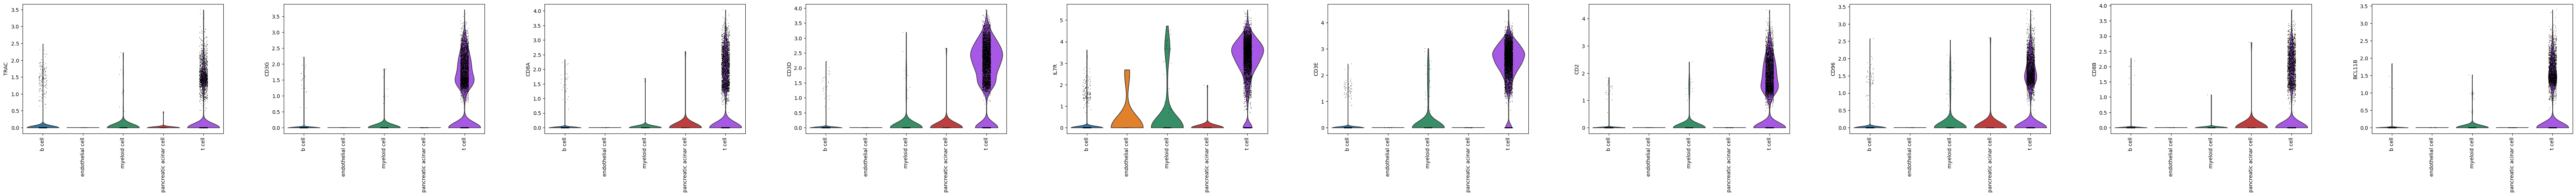

In [75]:
# Check expression of the twelve genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
genes_present = [gene for gene in top_20_genes if gene in adata.var_names]

# Select the top 10 from those present
top_10_genes_present = genes_present[:10]

# Create violin plot of expression by majority voting labels
sc.pl.violin(adata, top_10_genes_present, groupby='majority_voting', rotation=90)